# Creating a Camera Model
Here we load the previously created MDIS NAC ISD file and create a working camera model.  This notebook loads the ISD from file to keep the overall length short.  It is equally possible to simply create a camera model directly from the image and kernel data (with the SPICE calls directly populating a CSM ISD object).


In [1]:
import json
import gdal
import pyproj
import numpy as np

# CSM Imports
from cycsm.isd import Isd
import usgscam as cam

# Load / Create the ISD

In [2]:
with open('isd.isd', 'r') as f:
    i = Isd.load(f) 

In [3]:
i.param('omega')

2.25613869898165

In [4]:
i.param('phi')

0.09434616179037647

In [5]:
type(i)

cycsm.isd.Isd

# Create the Model
Here we mirror the CSM interface that requires that a plugin be created and a model generated from that plugin.

In [6]:
plugin = cam.mdis.MdisPlugin()
print('This plugin contains {} models.'.format(plugin.nmodels))
model = plugin.from_isd(i, plugin.modelname(1))

This plugin contains 1 models.


In [7]:
model

In [8]:
model.name

'UsgsAstroFrameMdisPluginCSM'

In [9]:
model.imageToGround(512, 512, 0)

[1129256.7251961431, -1599248.4677779423, 1455285.5207515764]

In [10]:
model.groundToImage(1129256.7251961431, -1599248.4677779423, 1455285.5207515764)

[512.0000000000069, 512.0000000000038]

# Profit

In [11]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/jlaura/anaconda3/envs/camera/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


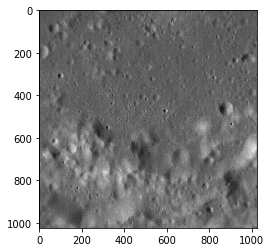

In [12]:
d = gdal.Open('../tests/data/EN1007907102M.cub')
arr = d.GetRasterBand(1).ReadAsArray()
imshow(arr, cmap='gray')

In [13]:
res = np.empty((arr.shape[0] * arr.shape[1], 4))
res[:,0] = arr.ravel()

In [14]:
size = model.imagesize
c = 0
for i in range(int(size[0])):
    for j in range(int(size[1])):
        x, y, z = model.imageToGround(i,j,0)
        idx = (i*j)
        res[c, 1] = x
        res[c, 2] = y
        res[c, 3] = z
        c += 1

In [15]:
import pandas as pd

In [16]:
df = pd.DataFrame(res, columns=['dn', 'x', 'y', 'z'])
#Setup to reproject
ecef = pyproj.Proj(proj='geocent', a=2439400, b=2439400)
lla = pyproj.Proj(proj='longlat', a=2439400, b=2439400)
x = df.x.values
y = df.y.values
z = df.z.values
lons, lats, alts = pyproj.transform(ecef, lla, x,y,z)

In [17]:
df = pd.DataFrame(np.vstack((lons, lats, df.dn.values)).T, columns=['longitude', 'latitude', 'dn'])

In [18]:
df.head(10)

,longitude,latitude,dn
0,-55.256872,36.831075,269.0
1,-55.256139,36.831243,269.0
2,-55.255406,36.831411,273.0
3,-55.254673,36.831579,271.0
4,-55.253939,36.831747,356.0
5,-55.253206,36.831915,366.0
6,-55.252473,36.832084,366.0
7,-55.251740,36.832252,366.0
8,-55.251007,36.832420,360.0
9,-55.250274,36.832588,363.0


In [19]:
model.illumination_direction([0,0,2394 * 1000])

[31648725087.588726, 60633907522.72863, 41123485.77334732]

In [20]:
model.image_to_remote_imaging_locus(512, 512)

({'x': 1728181.0340792781, 'y': -2088202.591297346, 'z': 2082707.608992824},
 {'x': -0.601502781824103, 'y': 0.4910591557549802, 'z': -0.6301232490609052})

In [21]:
model.sensor_coordinate_position(512, 512)

[1728181.0340792781, -2088202.591297346, 2082707.608992824]

# Now convert from Lat/Lon/DN into an interpolated raster

Modified from: http://gis.stackexchange.com/questions/177061/ascii-file-with-latitude-longitude-and-data-to-geotiff-using-python

In [22]:
import matplotlib.mlab as ml
# create grid
xmin, xmax, ymin, ymax = [min(df.longitude), max(df.longitude),
                          min(df.latitude), max(df.latitude)]
row, col = model.imagesize
xi = np.linspace(xmin, xmax, col)
yi = np.linspace(ymin, ymax, row)
xi, yi = np.meshgrid(xi, yi)

# linear interpolation
zi = ml.griddata(df.longitude, df.latitude, df.dn, xi, yi, interp='linear')
final_array = np.asarray(np.rot90(np.transpose(zi)))

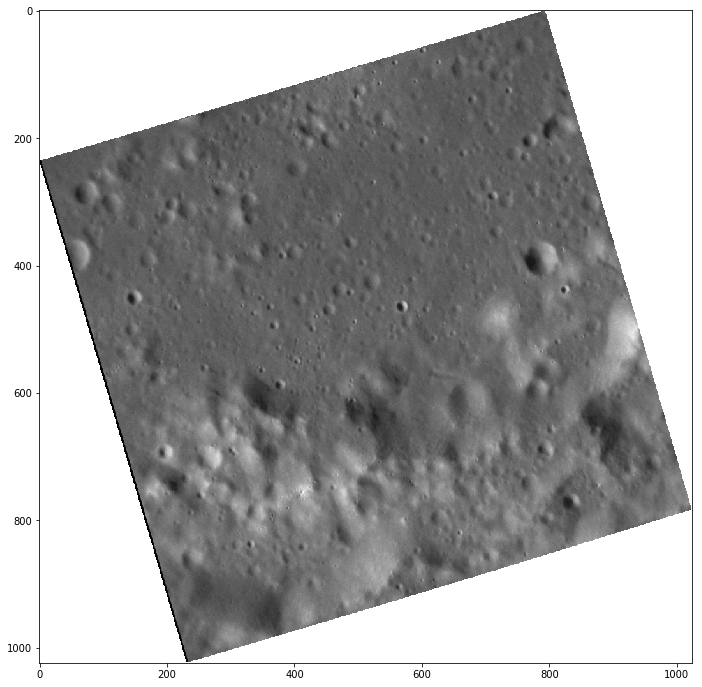

In [23]:
figsize(12,12)
imshow(final_array, cmap='gray')

# Write a geotiff
Still need to compute/add the geotransform (so QGIS will complain)

In [29]:
# projection
outfile = 'out.tif'
driver = gdal.GetDriverByName("GTiff")
dst_ds = driver.Create(outfile, int(col), int(row), 1, gdal.GDT_Byte)
dst_ds.GetRasterBand(1).WriteArray(final_array)
dst_ds.SetProjection(lla.srs)

# Have to manually compute and set the geotransform.
#gt = im.GetGeoTransform()
#dst_ds.SetGeoTransform(gt)
dst_ds = None

final_tif = gdal.Open(outfile).ReadAsArray()